In [294]:
import os
import csv

def convert_txt_file_to_csv(input_txt_path, output_dir, delimiter=','):
    """
    Reads a single .txt file from input_txt_path, converts it to .csv, and saves
    the new file inside output_dir with the same base name.

    :param input_txt_path: Full path to the input .txt file.
    :param output_dir: Directory where the .csv will be saved.
    :param delimiter: Delimiter used in the .txt file (default is comma).
    """

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get the base filename (e.g., 'error_CL_1.txt' -> 'error_CL_1')
    base_name = os.path.basename(input_txt_path)
    file_root, _ = os.path.splitext(base_name)

    # Construct output CSV path with same base name
    output_csv_path = os.path.join(output_dir, file_root + '.csv')

    with open(input_txt_path, 'r') as txt_file, open(output_csv_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Read each line from the .txt, split by delimiter, and write to CSV
        for line in txt_file:
            row_data = line.strip().split(delimiter)
            csv_writer.writerow(row_data)



In [295]:
file_names = [
    "airfoil_cm_lists_with_trip",
    "airfoil_cm_lists",
    "efficiencies_alfa_2",
    "efficiencies_alfa_with_trip",
    "efficiencies_CL_2",
    "efficiencies_CL_with_trip",
    "error_alfa_2",
    "error_alfa_with_trip",
    "error_CL_2",
    "error_CL_with_trip",
    "error_cm_with_trip"
]

for file_name in file_names:
    convert_txt_file_to_csv(
        input_txt_path="results_txt/" + file_name + ".txt",
        output_dir="results_csv",
        delimiter=","
    )


In [296]:
# This cell goes to each error files (except tripping) to update it with airfoil names that have efficiencies nan
def update_error_file(eff_file, error_file):
    """
    Check an efficiency file for rows with 'nan' efficiency and update
    the corresponding error file with the airfoil name(s) that have a nan efficiency.
    
    Parameters:
      eff_file (str): Path to the efficiency CSV file.
      error_file (str): Path to the corresponding error CSV file.
    """
    # Collect airfoil names from the efficiency file with 'nan' efficiency
    error_airfoils = set()
    with open(eff_file, 'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or len(row) < 2:
                continue  # skip empty or malformed rows
            airfoil = row[0].strip()
            efficiency = row[1].strip().lower()
            if efficiency == 'nan':
                error_airfoils.add(airfoil)
    
    if error_airfoils:
        # Read existing errors from the error file (if it exists) to avoid duplicates
        existing_errors = set()
        if os.path.exists(error_file):
            with open(error_file, 'r', newline='', encoding='utf-8') as f_err:
                reader = csv.reader(f_err)
                for row in reader:
                    if row:
                        existing_errors.add(row[0].strip())
        
        # Determine new airfoil names to add (avoid duplicates)
        new_errors = error_airfoils - existing_errors
        if new_errors:
            with open(error_file, 'a', newline='', encoding='utf-8') as f_error:
                writer = csv.writer(f_error)
                for airfoil in new_errors:
                    writer.writerow([airfoil])
            print(f"Updated {error_file} with airfoils: {list(new_errors)}")
        else:
            print(f"No new airfoils to add to {error_file}.")
    else:
        print(f"No 'nan' efficiency found in {eff_file}.")

# List the efficiency files with their corresponding error file paths.
file_mappings = [
    ('results_csv/efficiencies_alfa_2.csv', 'results_csv/error_alfa_2.csv'),
    ('results_csv/efficiencies_CL_2.csv',   'results_csv/error_CL_2.csv'),
]

# Process each mapping.
for eff_file, error_file in file_mappings:
    update_error_file(eff_file, error_file)


Updated results_csv/error_alfa_2.csv with airfoils: ['ames02.dat', 'e325.dat', 'goe459.dat', 'e228.dat', 'b707a.dat', 'r1145msm.dat', 'a63a108c.dat', 'b707b.dat', 'goe776.dat', 'mh46.dat', 'goe765.dat', 'prandtl-d-wingtip.dat', 'mh108.dat', 'mh49.dat', 'w1011.dat', 'lwk80150k25.dat', 'lwk80080.dat', 'goe460.dat', 'goe775.dat', 'fx76120.dat', 'e330.dat', 'mh93.dat', 'e230.dat', 'lwk80100.dat', 'e184.dat', 'esa40.dat', 'zv15_35.dat', 'e326.dat', 'n0011sc.dat', 'us1000root.dat', 'e335.dat', 'giiia.dat', 'ht35.dat', 'mh92.dat', 'goe445.dat', 'mh106.dat', 'mh110.dat', 'e186.dat', 'oaf139.dat', 'ultimate.dat', 'goe780.dat']
Updated results_csv/error_CL_2.csv with airfoils: ['ames02.dat', 'e325.dat', 'goe459.dat', 'e228.dat', 'b707a.dat', 'a63a108c.dat', 'b707b.dat', 'goe776.dat', 'mh46.dat', 'goe765.dat', 'prandtl-d-wingtip.dat', 'mh108.dat', 'mh49.dat', 'w1011.dat', 'lwk80150k25.dat', 'lwk80080.dat', 'goe460.dat', 'goe775.dat', 'fx76120.dat', 'e330.dat', 'mh93.dat', 'e230.dat', 'lwk80100.da

In [297]:
import ast
import csv

def get_airfoil_data(filename):
    """
    Reads the CSV file and returns a dictionary mapping the airfoil base name
    to its list of Cm values.
    """
    airfoil_data = {}
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            # Skip empty lines and header lines (e.g., "Airfoil,...")
            if not line or line.startswith("Airfoil"):
                continue

            # Split the line into two parts: airfoil name and the string of Cm values.
            # The '1' in split limits it to a single comma split.
            splitted = line.split(",", 1)
            if len(splitted) != 2:
                continue

            airfoil_name, cm_values_str = splitted
            # Remove the directory path, keeping only the file name (e.g., "ag45ct02r.dat")
            airfoil_name = airfoil_name.split("\\")[-1]
            
            # Convert the string representation of the list into an actual Python list.
            try:
                cm_values = ast.literal_eval(cm_values_str.strip())
            except Exception as e:
                print(f"Error parsing line: {line}\n{e}")
                continue

            airfoil_data[airfoil_name] = cm_values

    return airfoil_data

def find_max_airfoil(airfoil_data):
    """
    Finds and returns the airfoil with the maximum number of Cm values.
    Returns a tuple: (max_airfoil_name, number_of_points).
    """
    max_airfoil = None
    max_len = 0
    for name, values in airfoil_data.items():
        if len(values) > max_len:
            max_len = len(values)
            max_airfoil = name
    return max_airfoil, max_len

def check_errors(airfoil_data, reference_name="atr72sm.dat", min_points=12, threshold=0.15):
    """
    Checks each airfoil against two error conditions:
      1. The airfoil's list of Cm values has fewer than 'min_points' entries.
      2. For each airfoil (other than the reference), count the number of points (comparing
         corresponding indices up to the common length with the reference) where the relative
         difference exceeds the threshold (10% by default). If more than one point shows a difference
         greater than 10%, then flag the airfoil.
    
    Returns a set of airfoil names that meet either error condition.
    """
    error_airfoils = set()
    
    # Ensure the reference airfoil exists in the data.
    if reference_name not in airfoil_data:
        print(f"Reference airfoil '{reference_name}' not found in data.")
        return error_airfoils

    reference_cm = airfoil_data[reference_name]
    
    # Loop over each airfoil (skip the reference airfoil itself)
    for name, cm_values in airfoil_data.items():
        if name == reference_name:
            continue
        
        # Condition 1: Flag if the airfoil has fewer than min_points.
        if len(cm_values) < min_points:
            error_airfoils.add(name)
            continue

        # Condition 2: Count how many points differ from the reference by more than the threshold.
        diff_count = 0
        # Only compare up to the common length of both lists to avoid index errors.
        common_length = min(len(cm_values), len(reference_cm))
        for i in range(common_length):
            ref_val = reference_cm[i]
            airfoil_val = cm_values[i]
            # Avoid division by zero: if reference value is zero, then any non-zero is considered a difference.
            if ref_val == 0:
                if airfoil_val != 0:
                    diff_count += 1
            else:
                relative_diff = abs(airfoil_val - ref_val) / abs(ref_val)
                if relative_diff > threshold:
                    diff_count += 1

        # Accept the airfoil if at most one point exceeds the threshold;
        # flag it as error if more than one point exceeds the threshold.
        if diff_count > 1:
            error_airfoils.add(name)
    
    return error_airfoils

if __name__ == "__main__":
    # Define file paths.
    input_filename = "results_csv/airfoil_cm_lists.csv"  # Input CSV file with airfoil data
    error_filename = "results_csv/error_cm.csv"          # Output CSV file for error airfoils

    # Step 1: Read airfoil data from the CSV file.
    airfoil_data = get_airfoil_data(input_filename)

    # Step 2: Find the airfoil with the maximum number of Cm values.
    max_airfoil, max_len = find_max_airfoil(airfoil_data)

    # Step 3: Check for errors:
    #   - Airfoils with fewer than 12 points.
    #   - Airfoils with more than one point (up to the common length) that has a relative difference over 10%.
    error_airfoils = check_errors(airfoil_data, reference_name="atr72sm.dat", min_points=12, threshold=0.15)

    # Step 4: Write the error airfoil names to error_cm.csv (one airfoil name per row, one column).
    with open(error_filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        for airfoil_name in error_airfoils:
            writer.writerow([airfoil_name])

    # Step 5: Print the airfoil with the maximum number of points and its details.
    if max_airfoil is not None:
        print(f"Airfoil with the maximum number of points: {max_airfoil}")
        print(f"Number of Cm values: {max_len}")
        print(f"Cm values: {airfoil_data[max_airfoil]}")
    else:
        print("No valid airfoil data found in the file.")


Airfoil with the maximum number of points: a63a108c.dat
Number of Cm values: 12
Cm values: [0.00142, 0.00261, 0.00276, 0.00291, 0.00309, 0.00327, 0.00345, 0.00366, 0.00388, 0.00411, 0.00433, 0.00463]


In [298]:
# The goal of this cell is to gather all of airfoil names errors file in only one -> unique_airfoils.csv (I did not use the tripping errors files)
file_paths = [
    'results_csv/error_alfa_2.csv',
    'results_csv/error_CL_2.csv',
    'results_csv/error_cm.csv',
]

unique_airfoils = set()

for file_path in file_paths:
    with open(file_path, 'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            # If there's at least one element in this row, that's the airfoil name
            if row:
                airfoil_name = row[0].strip()
                if airfoil_name:  # ensure it's not an empty line
                    unique_airfoils.add(airfoil_name)

# Write all unique airfoils to a new CSV
output_file_path = 'results_csv/unique_airfoils.csv'
with open(output_file_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['airfoil_name'])  # Optional header
    for airfoil in sorted(unique_airfoils):
        writer.writerow([airfoil])



In [299]:
# This cell accessess all of the efficiency files and deletes all of error airfoils

# --------------------------------------------------
# 1) Load the reference airfoils from unique_airfoils.csv
# --------------------------------------------------
reference_file = 'results_csv/unique_airfoils.csv'
reference_airfoils = set()

with open(reference_file, 'r', newline='', encoding='utf-8') as ref_csv:
    reader = csv.reader(ref_csv)
    
    # If unique_airfoils.csv has a header (like "airfoil_name"),
    # skip it by reading one row without storing it:
    header_row = next(reader, None)
    
    # Now read the remaining lines (airfoil names)
    for row in reader:
        # Each row is presumably one name per line
        if row:
            airfoil_name = row[0].strip()
            reference_airfoils.add(airfoil_name)

# --------------------------------------------------
# 2) Define the list of target CSV files to be cleaned
# --------------------------------------------------
file_paths_to_clean = [
    # Replace these with the paths to your "attached" files
    'results_csv/efficiencies_alfa_2.csv',
    'results_csv/efficiencies_CL_2.csv',

    # Add as many as needed
]

# --------------------------------------------------
# 3) For each file, remove rows where the first column
#    matches an entry in reference_airfoils
# --------------------------------------------------
for file_path in file_paths_to_clean:
    new_contents = []
    
    with open(file_path, 'r', newline='', encoding='utf-8') as original_csv:
        reader = csv.reader(original_csv)
        
        # If these files have a header, read it once and store it:
        header = next(reader, None)
        
        # Optional: If you want to keep the header row, add it to new_contents
        # BUT only if you are sure the first row is indeed a header.
        # If there's no header, comment these lines out.
        if header:
            new_contents.append(header)
        
        # Now read each data row
        for row in reader:
            if not row:
                continue  # skip empty lines if present
            
            # The airfoil name is assumed to be in the first column
            airfoil_in_file = row[0].strip()
            
            # Only keep the row if the airfoil is NOT in the reference set
            if airfoil_in_file not in reference_airfoils:
                new_contents.append(row)
    
    # Overwrite the original file with the filtered data
    with open(file_path, 'w', newline='', encoding='utf-8') as cleaned_csv:
        writer = csv.writer(cleaned_csv)
        writer.writerows(new_contents)


In [300]:
def compare_efficiencies(alfa_file, cl_file, output_file):
    """
    Compare efficiencies from two CSV files that do NOT have headers.
    Assumes:
      - Column 0: airfoil name
      - Column 1: efficiency (a number)
    The difference is computed as:
         (efficiency from alfa_file) - (efficiency from cl_file)
    The output file is written with a header row and includes 4 columns:
      - airfoil
      - efficiency_alfa
      - efficiency_CL
      - efficiency_difference
    """
    # Read efficiencies from the alfa file into a dictionary: airfoil -> efficiency
    efficiencies_alfa = {}
    with open(alfa_file, 'r', newline='', encoding='utf-8') as f_alfa:
        reader = csv.reader(f_alfa)
        for row in reader:
            if not row or len(row) < 2:
                continue
            airfoil = row[0].strip()
            try:
                eff = float(row[1])
            except ValueError:
                continue  # Skip rows with non-numeric efficiency
            efficiencies_alfa[airfoil] = eff

    # Read efficiencies from the CL file into a dictionary: airfoil -> efficiency
    efficiencies_cl = {}
    with open(cl_file, 'r', newline='', encoding='utf-8') as f_cl:
        reader = csv.reader(f_cl)
        for row in reader:
            if not row or len(row) < 2:
                continue
            airfoil = row[0].strip()
            try:
                eff = float(row[1])
            except ValueError:
                continue
            efficiencies_cl[airfoil] = eff

    # Compute the efficiency difference for airfoils present in both files
    results = []
    for airfoil, eff_alfa in efficiencies_alfa.items():
        if airfoil in efficiencies_cl:
            eff_cl = efficiencies_cl[airfoil]
            diff = eff_alfa - eff_cl
            results.append([airfoil, eff_alfa, eff_cl, diff])

    # Write the results to the output CSV file, including a header row with 4 columns
    with open(output_file, 'w', newline='', encoding='utf-8') as fout:
        writer = csv.writer(fout)
        writer.writerow(['airfoil', 'efficiency_alfa', 'efficiency_CL', 'efficiency_difference'])
        writer.writerows(results)
    
    print(f"Created file: {output_file} with {len(results)} rows.")


# --- Compare the second pair: efficiencies_alfa_2.csv vs efficiencies_CL_2.csv ---
alfa_file_2 = 'results_csv/efficiencies_alfa_2.csv'
cl_file_2   = 'results_csv/efficiencies_CL_2.csv'
output_file_2 = 'results_csv/efficiencies_diff_2.csv'
compare_efficiencies(alfa_file_2, cl_file_2, output_file_2)


Created file: results_csv/efficiencies_diff_2.csv with 90 rows.


In [301]:
def filter_efficiency_range(input_file, output_file, low=-3, high=3):
    """
    Reads input_file (assumed to be a CSV with headers:
    'airfoil', 'efficiency_alfa', 'efficiency_CL', and 'efficiency_difference'),
    filters rows where the efficiency_difference is between low and high (inclusive),
    and writes the filtered rows to output_file including all four columns.
    """
    filtered_rows = []
    
    with open(input_file, 'r', newline='', encoding='utf-8') as fin:
        reader = csv.DictReader(fin)
        for row in reader:
            try:
                diff = float(row['efficiency_difference'])
            except (ValueError, KeyError):
                continue  # Skip rows that don't have a valid number in efficiency_difference
            if low <= diff <= high:
                filtered_rows.append(row)
    
    # Write the filtered data to the output CSV file with all four columns.
    with open(output_file, 'w', newline='', encoding='utf-8') as fout:
        fieldnames = ['airfoil', 'efficiency_alfa', 'efficiency_CL', 'efficiency_difference']
        writer = csv.DictWriter(fout, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(filtered_rows)
    
    print(f"Created file: {output_file} with {len(filtered_rows)} rows within the range {low} to {high}.")

# Define the input and output file paths.
files_to_filter = [
    ('results_csv/efficiencies_diff_2.csv', 'results_csv/efficiencies_diff_range_2.csv')
]

for input_file, output_file in files_to_filter:
    filter_efficiency_range(input_file, output_file, low=-3, high=3)

Created file: results_csv/efficiencies_diff_range_2.csv with 13 rows within the range -3 to 3.


         airfoil  efficiency_alfa  efficiency_CL  efficiency_difference  \
0    atr72sm.dat          75.6057        74.3157                 1.2900   
2       e542.dat          86.1577        84.7936                 1.3641   
3       e636.dat          79.7734        80.2867                -0.5133   
4       e338.dat          78.0630        79.8916                -1.8286   
5       e343.dat          78.0391        78.8251                -0.7860   
6   fx78k161.dat          88.8184        91.0966                -2.2782   
9      oa213.dat          77.5561        76.1453                 1.4108   
10  nl722362.dat          76.8040        74.0615                 2.7425   

    efficiency_mean  
0          74.96070  
2          85.47565  
3          80.03005  
4          78.97730  
5          78.43210  
6          89.95750  
9          76.85070  
10         75.43275  


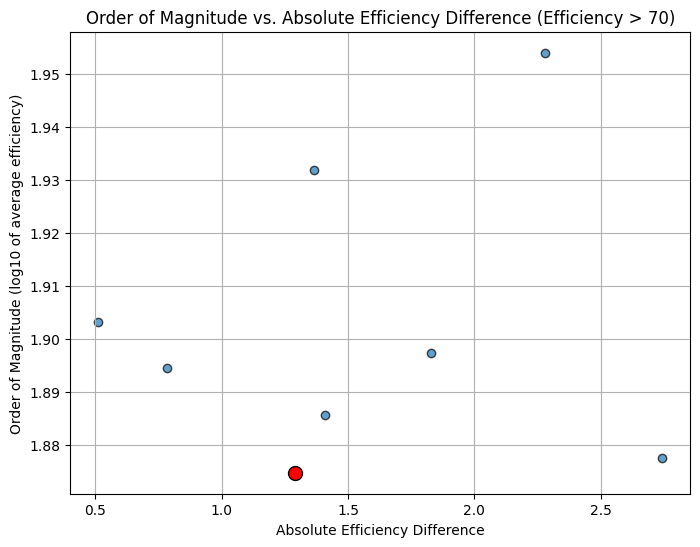

In [302]:
# 1. Load the CSV file into a DataFrame
df = pd.read_csv('results_csv/efficiencies_diff_range_2.csv')

# 2. Compute the average efficiency from the alfa and CL columns
df['efficiency_mean'] = (df['efficiency_alfa'] + df['efficiency_CL']) / 2.0

# 3. Filter to keep airfoils with 75 < efficiency_mean < 100
df = df[(df['efficiency_mean'] > 70)]
print(df)

# 4. Compute the order of magnitude (log10) of the average efficiency
df['eff_order'] = np.log10(df['efficiency_mean'])

# 5. Compute the absolute value of the efficiency difference
df['abs_diff'] = df['efficiency_difference'].abs()

# 6. Create a scatter plot for all filtered airfoils
plt.figure(figsize=(8,6))
plt.scatter(
    df['abs_diff'],    # x-axis: absolute efficiency difference
    df['eff_order'],   # y-axis: log10(average efficiency)
    alpha=0.7,
    edgecolor='k'
)

# 7. Highlight the "atr72sm.dat" reference point in red
ref_point = df[df['airfoil'] == 'atr72sm.dat']
if not ref_point.empty:
    plt.scatter(
        ref_point['abs_diff'],
        ref_point['eff_order'],
        s=100,         # larger marker size
        color='red',   # distinct color
        edgecolor='k',
        zorder=5       # ensure it appears on top
    )

# 8. Label axes and show the plot
plt.xlabel('Absolute Efficiency Difference')
plt.ylabel('Order of Magnitude (log10 of average efficiency)')
plt.title('Order of Magnitude vs. Absolute Efficiency Difference (Efficiency > 70)')
plt.grid(True)
plt.show()